In [1]:
from IPython.display import clear_output

# Content

In this notebook we will finetune a transformer network taken from huggingface, using huggingface's Trainer API

we will train facebook's mbart model to create a two way chinese to urdu language translator.

The reason for chosing mbart as the source model is because it has already seen a lot of languages's data(50 in our case) during pre-training

you can find more information about mbart on [hugging face](https://huggingface.co/facebook/mbart-large-50)

In [2]:
# %pip install gdown
# %pip install evaluate
# %pip install pandas
# %pip install sentencepiece
# %pip install accelerator
# %pip install protobuf==3.20.3
# %pip install matplotlib
# %pip install transformers datasets

# %pip install --disable-pip-version-check \
#     torch \
#     torchdata --quiet

# %pip install tqdm

clear_output()

In [3]:
# %pip install datasets
# # %pip install transformers[torch]  # [torch] because Trainer API with torch needs accelerator installed. This takes care of that. Might need a restart of the session
# # %pip install gdown==4.5
# %pip install evaluate
# %pip install rouge_score
# # 
# clear_output()

In [2]:
import math
from datasets import Dataset
from transformers import GenerationConfig, TrainingArguments, Trainer, TrainerCallback
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch
import pandas as pd
import evaluate
from tqdm import tqdm
import json

import matplotlib.pyplot as plt

import random

## Downloading the data

In [3]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Abdulmohsena/Classic-Arabic-English-Language-Pairs")


In [4]:
# Explore the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['en', 'ar'],
        num_rows: 20364
    })
})


In [5]:
random.seed(7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
device

'cuda'

In [7]:
from sklearn.model_selection import train_test_split
# Convert to pandas DataFrames
train_data = pd.DataFrame(dataset['train'])

# First split into train and test
train_data_full, test_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_data = train_data_full.head(5000)  
test_data = test_data.head(1000) 

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")



Training data shape: (5000, 2)
Testing data shape: (1000, 2)


In [8]:
# Sample of the data
train_data.head()

,en,ar
7792,"The greater the burden, the more you must be c...",وبقدر عظمها يجب التكليف من الله عليها؛ فبقدر م...
10285,"Before that, when he was the emir of the city,...",فأما قبلها، وهو أمير المدينة، فكان يسمع الغناء...
586,"Then the people are called to prayer, and thei...",ثم يؤذن للناس، وتؤخذ رقاعهم فينظر فيها.
10493,Have I not informed you? The believer is the o...,ألا أخبركم بالمؤمن من أمنه الناس على أموالهم و...
10590,These muscles should be less fleshy at the sec...,ويجب أن تكون هذه العضلات عند المقاطع أقل لحمية...


In [9]:
train_dataset = Dataset.from_pandas(train_data, split='train')
test_dataset = Dataset.from_pandas(test_data, split='test')

## Prepare the model and tokenizers

In [10]:
model_name='facebook/mbart-large-50'

model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer1 = MBart50TokenizerFast.from_pretrained(model_name, src_lang="en_XX", tgt_lang="ar_AR")
tokenizer2 = MBart50TokenizerFast.from_pretrained(model_name, src_lang="ar_AR", tgt_lang="en_XX")

In [11]:
def tokenize_function(rows):
    src_language = 'en'
    tgt_language = 'ar'

    # Randomly swap source and target language for data augmentation
    if random.randint(0, 1) == 1:
        src_language, tgt_language = tgt_language, src_language

    src_tokenizer, tgt_tokenizer = [get_apt_tokenizer(language) for language in (src_language, tgt_language)]

    start_prompt = f''
    end_prompt = f''
    prompt = [start_prompt + row + end_prompt for row in rows[src_language]]
    rows['src_language'] = [src_language] * len(rows[src_language])
    rows['prompt'] = prompt
    encoding = src_tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt", max_length=256)
    rows['input_ids'], rows['attention_mask'] = encoding.input_ids, encoding.attention_mask
    rows['labels'] = tgt_tokenizer(rows[tgt_language], padding="max_length", truncation=True, return_tensors="pt", max_length=256).input_ids

    return rows

def get_apt_tokenizer(src_language):
    if src_language.lower() == 'en':
        return tokenizer1  # English tokenizer
    elif src_language.lower() == 'ar':
        return tokenizer2  # Arabic tokenizer
    else:
        raise ValueError('Invalid Language')

In [12]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## Check to see tokenizer is working correctly by encoding and decoding

In [13]:
idx = 3
row = tokenized_test_dataset[idx]
tokenizer = get_apt_tokenizer(row['src_language'])

print(f'{row["src_language"]=}')
print(f'English: {row["en"]}')
print(f'Arabic: {row["ar"]}')
print(f'Input decoded: {tokenizer.decode(row["input_ids"], skip_special_tokens=True)}')
print(f'Label decoded: {tokenizer.decode(row["labels"], skip_special_tokens=True)}')

row["src_language"]='en'
English: He said: Your neglected and abandoned servant, my master Isaac. He said: He will be present at once.
Arabic: ! قال: عبدك المجفو المطرح، ياسيدي إسحاق قال: يحضر الساعة.
Input decoded: He said: Your neglected and abandoned servant, my master Isaac. He said: He will be present at once.
Label decoded: ! قال: عبدك المجفو المطرح، ياسيدي إسحاق قال: يحضر الساعة.


In [14]:
tokenized_train_dataset.shape

(5000, 8)

In [15]:
tokenized_train_dataset = tokenized_train_dataset.shuffle(seed=13)
tokenized_test_dataset = tokenized_test_dataset.shuffle(seed=13)

In [16]:
print(tokenized_train_dataset.shape)
tokenized_train_dataset

(5000, 8)


Dataset({
    features: ['en', 'ar', '__index_level_0__', 'src_language', 'prompt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

## Pre-trained model

In [17]:
sample_english = "He said: Your neglected and abandoned servant, my master Isaac. He said: He will be present at once."
with torch.no_grad():
    res = model.generate(**tokenizer1(sample_english, return_tensors='pt'))
tokenizer1.batch_decode(res)[0]

'</s><s> He said: Your neglected and abandoned servant, my master Isaac. He said: He will be present at once.</s>'

In [18]:
sample_arabic = "قال: عبدك المجفو المطرح، ياسيدي إسحاق قال: يحضر الساعة."
with torch.no_grad():
    res = model.generate(**tokenizer2(sample_arabic, return_tensors='pt'))
tokenizer2.batch_decode(res)[0]

'</s><s> قال: عبدك المجفو المطرح، ياسيدي إسحاق قال: يحضر الساعة.</s>'

## Training the model

In [19]:
# Create empty lists for storing losses
train_losses = []
val_losses = []

In [35]:
output_dir = f'./checkpoints/mbart-large-translator-full-run'

training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=5e-5,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    warmup_steps=100,
    report_to="none"  # Disable reporting to avoid clutter
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.654600,0.384585
2,0.724900,0.346233
3,0.489500,0.344470
4,0.172400,0.369305
5,0.107400,0.382018


/ibex/user/habiam0b/miniconda3/envs/GPU/lib/python3.9/site-packages/transformers/modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=3125, training_loss=0.8297602197265626, metrics={'train_runtime': 2977.6024, 'train_samples_per_second': 8.396, 'train_steps_per_second': 1.05, 'total_flos': 1.35445610496e+16, 'train_loss': 0.8297602197265626, 'epoch': 5.0})

In [37]:
# After training, collect all losses from the log history
for log in trainer.state.log_history:
    if "loss" in log and "eval_loss" not in log:
        train_losses.append(log["loss"])
    elif "eval_loss" in log:
        val_losses.append(log["eval_loss"])

# Print the losses
print("Training losses:", train_losses)
print("Validation losses:", val_losses)

Training losses: [2.6546, 0.7249, 0.4895, 0.1724, 0.1074]
Validation losses: [0.38458487391471863, 0.3462332785129547, 0.34446996450424194, 0.3693047761917114, 0.3820178210735321]


In [38]:
model.save_pretrained('mbart_5ep_full_finetuned_bidir')

In [20]:
# Load the model
model = MBartForConditionalGeneration.from_pretrained('mbart_5ep_full_finetuned_bidir')

In [35]:
model.to(device)
1

1

In [23]:
sample_english = "The greater the burden, the more you must be charged with it by God. The greater the blessing He has bestowed upon you, the more you must be thankful"
with torch.no_grad():
    encoding = tokenizer1(sample_english, return_tensors='pt')
    input_ids, attn_mask = encoding.input_ids.to(model.device), encoding.attention_mask.to(model.device)
    # Add forced_bos_token_id for Arabic
    res = model.generate(
        input_ids=input_ids, 
        attention_mask=attn_mask,
        forced_bos_token_id=tokenizer1.lang_code_to_id["ar_AR"]
    )
print(tokenizer1.batch_decode(res)[0])

</s>ar_AR وكلما كان العبء أكثر احتيج أن تثق به عند الله وكلما كان النعمة التي أنعم عليك بها أكثر احتيج أن تشكر</s>


In [24]:
sample_arabic = "كلما زاد العبء، كلما كان عليك أن تتحمله من الله. كلما كانت البركة التي منحها لك أكبر، كلما كان عليك أن تكون أكثر امتنانًا"
with torch.no_grad():
    encoding = tokenizer2(sample_arabic, return_tensors='pt')
    input_ids, attn_mask = encoding.input_ids.to(model.device), encoding.attention_mask.to(model.device)
    # Add forced_bos_token_id for English
    res = model.generate(
        input_ids=input_ids, 
        attention_mask=attn_mask,
        forced_bos_token_id=tokenizer2.lang_code_to_id["en_XX"]
    )
print(tokenizer2.batch_decode(res)[0])

</s>en_XX The more you must bear the burden, the more you must bear it from God. The more blessings He has granted to you, the more you must be grateful for Him.</s>


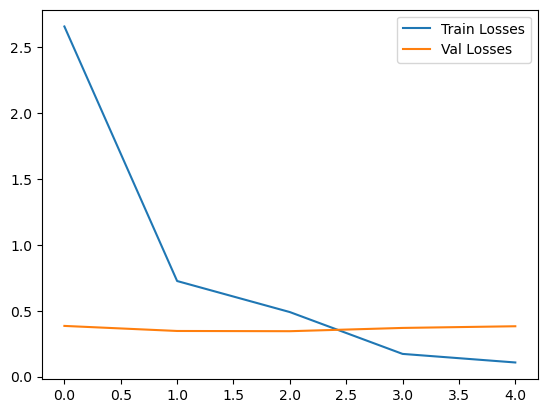

In [40]:
plt.plot(train_losses, label='Train Losses')
plt.plot(val_losses, label='Val Losses')

plt.legend()
plt.show()

## Evaluating the results

In [23]:
bleu = evaluate.load('bleu')

In [71]:
untrained_model = MBartForConditionalGeneration.from_pretrained(model_name)
untrained_model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=

In [72]:
cn_to_ur_data = test_data.sample(frac=0.5, random_state=123)
ur_to_cn_data = test_data.loc[test_data.index.difference(cn_to_ur_data.index)]

In [73]:
batch_size = 16

num_batches = int(math.ceil(len(cn_to_ur_data)/batch_size))

all_untrained_model_outputs = []
all_trained_model_outputs = []

for i in tqdm(range(num_batches)):

    batch_start = i*batch_size
    batch_end = batch_start + batch_size

    batch_df = cn_to_ur_data.iloc[batch_start:] if i == num_batches - 1 else cn_to_ur_data.iloc[batch_start: batch_end]

    prompts = [f'{chinese}' for chinese in batch_df['en']]

    with torch.no_grad():

        encodings = tokenizer1(prompts, return_tensors="pt", padding="max_length", truncation=True, max_length=256)

        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)

        model_outputs = untrained_model.generate(input_ids=input_ids,
                                                         attention_mask=attention_mask,
                                                         generation_config=GenerationConfig(max_new_tokens=256))
        model_text_output = tokenizer1.batch_decode(model_outputs, skip_special_tokens=True)
        all_untrained_model_outputs.extend(model_text_output)

        trained_model_outputs = model.generate(input_ids=input_ids,
                                                 attention_mask=attention_mask,
                                                 generation_config=GenerationConfig(max_new_tokens=256))
        trained_model_text_output = tokenizer1.batch_decode(trained_model_outputs, skip_special_tokens=True)
        all_trained_model_outputs.extend(trained_model_text_output)

100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [02:38<00:00,  4.96s/it]


In [74]:
len(all_untrained_model_outputs)

500

In [75]:
len(all_trained_model_outputs)

500

In [76]:
cn_to_ur_data['trained_model_urdu'] = all_trained_model_outputs
cn_to_ur_data['untrained_model_urdu'] = all_untrained_model_outputs

In [79]:
predictions_untrained = cn_to_ur_data['untrained_model_urdu'].tolist()
predictions_trained = cn_to_ur_data['trained_model_urdu'].tolist()
references_raw = cn_to_ur_data['ar'].tolist()

references = [[ref] for ref in references_raw]

predictions_untrained = [str(pred) for pred in predictions_untrained]
predictions_trained = [str(pred) for pred in predictions_trained]
references = [[str(ref)] for ref in references_raw]

original_bleu = bleu.compute(
    predictions=predictions_untrained,
    references=references,
)

trained_bleu = bleu.compute(
    predictions=predictions_trained,
    references=references,
)

In [80]:
print('Chinese to Urdu')
print('Original model:')
print(json.dumps(original_bleu, indent=2))
print('Trained model:')
print(json.dumps(trained_bleu, indent=2))

Chinese to Urdu
Original model:
{
  "bleu": 0.0,
  "precisions": [
    0.005537920088330688,
    0.00010441319782820548,
    0.0,
    0.0
  ],
  "brevity_penalty": 1.0,
  "length_ratio": 5.488495407631853,
  "translation_length": 57964,
  "reference_length": 10561
}
Trained model:
{
  "bleu": 0.03633769150296854,
  "precisions": [
    0.17083333333333334,
    0.052702984763097475,
    0.02212681638044914,
    0.010592480502851822
  ],
  "brevity_penalty": 0.9534023665735639,
  "length_ratio": 0.9544550705425623,
  "translation_length": 10080,
  "reference_length": 10561
}
